In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers
from tensorflow.keras.losses import categorical_crossentropy

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sp_au\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sp_au\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [5]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'],nrows=50000)

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of        overall_rating                                        review_text
0                   4  Estou contente com a compra entrega rápida o ú...
1                   4  Por apenas R$1994.20,eu consegui comprar esse ...
2                   4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                   4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                   5  A entrega foi no prazo, as americanas estão de...
...               ...                                                ...
49995               5  É com muito prazer que avalio esse produto! Si...
49996               4  é uma bicicleta bonita e bonita, com o tempo v...
49997               5  O produto chegou 8 dias antes do prazo e em pe...
49998               2  O produto até chegou dentro do prazo, só que e...
49999               5  Excelente! Superou minhas expectativas! Ótimo ...

[50000 rows x 2 columns]>


In [6]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [7]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [8]:
print(b2wCorpus.head)

<bound method NDFrame.head of        overall_rating                                        review_text
0                   4  contente compra entrega rapida unico problema ...
1                   4        apenas consegui comprar lindo copo acrilico
2                   4  supera agilidade praticidade outras panelas el...
3                   4          filho amou parece verdade tantos detalhes
4                   5  entrega prazo americanas estao parabens smart ...
...               ...                                                ...
49995               5  prazer avalio produto simplesmente maravilhoso...
49996               4  bicicleta bonita bonita tempo veremos durabili...
49997               5    produto chegou dias antes prazo perfeito estado
49998               2  produto ate chegou dentro prazo so espero nunc...
49999               5  excelente superou expectativas otimo desempenh...

[50000 rows x 2 columns]>


In [9]:
b2wCorpus.overall_rating .value_counts().sort_index()

1     9538
2     3179
3     6121
4    12529
5    18633
Name: overall_rating, dtype: int64

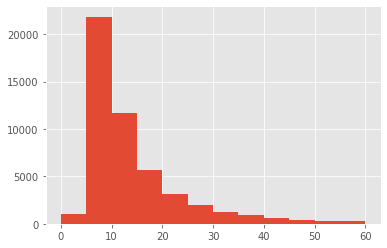

49169


In [10]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=60 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [11]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of        overall_rating                                        review_text
0                   5     amei resultado produto recomendaria sim amigas
1                   5  entrega rapida previsto veio tudo bem embalado...
2                   4  recomendo produtos otima qualidade entrega rap...
3                   4  funciona blz faz carnes pao alho rapido gostei...
4                   2  funciona propoe boa qualidade porem ter pecas ...
...               ...                                                ...
49995               1  opiniao americanas pessimo lugar efetuar compr...
49996               3  nao usei ainda xbox nao chegou esperando chega...
49997               4  produto otimo faz diversos paes ainda posso pr...
49998               1      contato fabricante dificilimo nao dao solucao
49999               4  vale relogio leve duravel pratico infelizmente...

[50000 rows x 2 columns]>


In [12]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [13]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [14]:
b2wCorpus.shape

(50000, 3)

In [15]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 5].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 50].index)

In [16]:
b2wCorpus['overall_rating'] = b2wCorpus.overall_rating.apply(lambda x: x - 1)

In [17]:
b2wCorpus.shape

(47628, 3)

In [18]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [19]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,4,"[16476, 484, 902, 62443, 209, 7310]",6
1,4,"[2499, 85324, 1322, 930, 122, 70, 21144, 202, ...",18
2,3,"[22522, 323, 161274, 532, 2499, 85324, 16476]",7
3,3,"[2424, 0, 234, 9710, 52444, 16377, 61637, 6376...",9
4,1,"[2424, 0, 363, 532, 17382, 69, 188512, 0, 0, 7...",30


In [20]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [21]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=50, padding='post').tolist()

In [22]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,4,"[16476, 484, 902, 62443, 209, 7310, 0, 0, 0, 0...",6
1,4,"[2499, 85324, 1322, 930, 122, 70, 21144, 202, ...",18
2,3,"[22522, 323, 161274, 532, 2499, 85324, 16476, ...",7
3,3,"[2424, 0, 234, 9710, 52444, 16377, 61637, 6376...",9
4,1,"[2424, 0, 363, 532, 17382, 69, 188512, 0, 0, 7...",30


In [23]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [24]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [25]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
17635,0,"[0, 123, 403, 5841, 32165, 110, 25236, 565, 71...",50
21306,4,"[1664, 728, 304, 2759, 345, 297, 2499, 1761, 9...",50
19565,0,"[7804, 41933, 0, 18874, 110, 3093, 902, 8201, ...",50
11546,0,"[902, 7804, 428, 62, 2294, 948, 1912, 1150, 13...",50
46333,1,"[9735, 35919, 16299, 102, 20671, 225, 4339, 25...",50


In [26]:
b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
29767               3  [394, 976, 717, 11763, 47683, 52658, 129, 134,...   50
34512               2  [4402, 39, 2905, 6774, 818, 764, 164, 26224, 1...   50
47508               0  [2989, 0, 12783, 306, 1304, 522, 5291, 245, 78...   50
10402               0  [45850, 10570, 0, 8567, 4339, 17715, 14762, 86...   50
40260               0  [13478, 31505, 106, 10071, 9968, 1705, 1812, 1...   50
...               ...                                                ...  ...
43894               4  [532, 561, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    5
18548               4  [226, 3893, 362, 28129, 21362, 0, 0, 0, 0, 0, ...    5
24767               4  [678, 4853, 958, 112734, 14911, 0, 0, 0, 0, 0,...    5
15624               4  [5185, 2104, 18236, 4010, 0, 0, 0, 0, 0, 0, 0,...    5
16950               4  [226, 902, 8201, 3993, 22522, 0, 0, 0, 0, 0, 0...    5

[4762 rows x 3 columns]>

In [27]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
15762               0  [239, 362, 612, 902, 9735, 5437, 169, 1806, 13...   50
43832               0  [26382, 20907, 5547, 30029, 6689, 293, 61, 252...   50
33328               4  [8557, 3690, 902, 0, 39, 11471, 935, 1313, 553...   50
39200               1  [902, 44379, 0, 15035, 38352, 330, 109923, 281...   50
9374                0  [7804, 41933, 0, 9391, 2215, 7256, 134, 86, 10...   50
...               ...                                                ...  ...
17509               3  [7126, 202, 1771, 22522, 902, 0, 0, 0, 0, 0, 0...    5
35187               2  [7804, 2048, 0, 3528, 39, 0, 0, 0, 0, 0, 0, 0,...    5
41592               4  [16476, 902, 1645, 2294, 3036, 0, 0, 0, 0, 0, ...    5
37500               3  [226, 47062, 33424, 185, 0, 0, 0, 0, 0, 0, 0, ...    5
24796               0  [2499, 20342, 5993, 43450, 13662, 0, 0, 0, 0, ...    5

[11908 rows x 3 columns]>

In [28]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [29]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train =  [ emb for emb in b2wCorpusTrain.review_text]
y_train =   b2wCorpusTrain.overall_rating
x_val = [ emb for emb in b2wCorpusValidate.review_text ]
y_val = b2wCorpusValidate.overall_rating
x_train = np.asarray(x_train)
x_val =np.asarray(x_val)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()


In [46]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
SEQUENCE_MAXLEN = 50
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)
model.add(layers.LSTM(64, dropout=0.25, return_sequences=True))
model.add(keras.layers.LSTM(64, dropout=0))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))
#opt = tf.keras.optimizers.SGD(learning_rate=.1, momentum=.5)
#opt = tf.keras.optimizers.Adamax(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
#model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc', 'mae'])
opt="adam"
model.compile(optimizer=opt,loss=sparse_categorical_crossentropy, metrics=["accuracy"])
history = model.fit(
    x= x_train, y=y_train, batch_size=24, epochs=50, validation_data=(x_val, y_val)
)

Epoch 1/50
1290/1290 [==============================] - 31s 24ms/step - loss: 1.2565 - accuracy: 0.4756 - val_loss: 1.1773 - val_accuracy: 0.4985
Epoch 2/50
1290/1290 [==============================] - 31s 24ms/step - loss: 1.1700 - accuracy: 0.5042 - val_loss: 1.1132 - val_accuracy: 0.5124
Epoch 3/50
1290/1290 [==============================] - 29s 23ms/step - loss: 1.1333 - accuracy: 0.5109 - val_loss: 1.0951 - val_accuracy: 0.5193
Epoch 4/50
1290/1290 [==============================] - 30s 23ms/step - loss: 1.1102 - accuracy: 0.5196 - val_loss: 1.1029 - val_accuracy: 0.5279
Epoch 5/50
1290/1290 [==============================] - 30s 23ms/step - loss: 1.0936 - accuracy: 0.5254 - val_loss: 1.0506 - val_accuracy: 0.5281
Epoch 6/50
1290/1290 [==============================] - 30s 23ms/step - loss: 1.0761 - accuracy: 0.5336 - val_loss: 1.0420 - val_accuracy: 0.5475
Epoch 7/50
1290/1290 [==============================] - 30s 23ms/step - loss: 1.0586 - accuracy: 0.5425 - val_loss: 1.0283 -

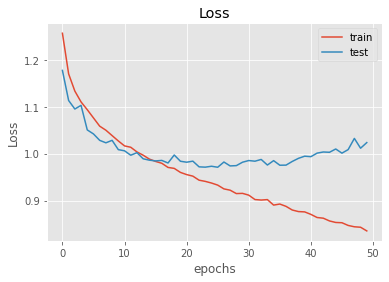

In [47]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

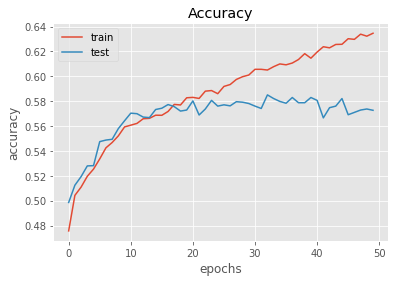

In [48]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();